# Stock Market Volatility Prediction using Sentiment Analysis


1. Project Overview
2. Data Collection
3. Data Preprocessing
4. Feature Engineering
    - Technical Indicators
    - Sentiment Features
5. Modeling
    - Baseline Linear Regression
    - Regularized Models (Ridge, Lasso)
    - Tree-Based Models (Random Forest, Gradient Boosting)
    - MLP Regressor
6. Model Evaluation & Validation
    - Metric Comparison Table
    - Walk - Forward Validation

7. Interpretation & Analysis
    - Model Behavior Analysis
    
8. Final Report & Next Steps

## Project Overview 
This notebook predicts next-day stock volatility using a combination of:
- **Historical OHLCV stock data** from Yahoo Finance
- **News sentiment analysis** using financial headlines
- **Technical indicators** (RSI, MACD, EMA) for market signals
- **Multiple ML models** to capture different patterns in volatility

**Target Variable**: Daily price volatility percentage = (High - Low) / Open × 100


### Key Imports 

In [139]:
# data imports
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# date and time handling
from datetime import datetime, timedelta

# stock data import
import yfinance as yf

# visual & plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
color_palette = ['#6A5ACD', '#4169E1', '#1E90FF', '#00BFFF', '#87CEEB']
sns.set_palette(color_palette)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# technical features
from ta.trend import EMAIndicator, MACD
from ta.momentum import RSIIndicator

# sentiment analysis
from textblob import TextBlob

# News API
import requests
from datetime import timedelta
import time

# model interpretation
import shap

# ML imports
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline

from pathlib import Path

### Setup & Configuration

In [14]:
# Stock selection (REPLACE TICKER DETAILS AS REQUIRED) 
STOCK_TICKER = "TSLA" 
PERIOD = "2y" 
INTERVAL = "1d"  

# add your own news_api key
NEWSAPI_KEY = "8f160b733e194588a433aa97baafa4fa"  
COMPANY_NAME = "Tesla" 
NEWS_QUERY = "Tesla OR TSLA"

DATA_DIR = Path("data")
RAW_DATA_DIR = DATA_DIR / "raw"

# Create directories
for dir_path in [DATA_DIR, RAW_DATA_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

### DATA COLLECTION
### Stock Data Collection

In [45]:
print("COLLECTING STOCK DATA")

def collect_stock_data(ticker, period="2y", interval="1d"):
    try:
        print(f"Fetching {ticker} data for period: {period}")
        
        stock = yf.Ticker(ticker)
        df = stock.history(period=period, interval=interval)
        
        df = df.reset_index()
        
        df.columns = [col.replace(' ', '_').lower() for col in df.columns]
        
        df['ticker'] = ticker
        
        print(f"Successfully collected {len(df)} days of data")
        print(f"Date range: {df['date'].min().date()} to {df['date'].max().date()}")
        
        return df
        
    except Exception as e:
        print(f" Error collecting data for {ticker}: {str(e)}")
        return None

df_stock = collect_stock_data(STOCK_TICKER, PERIOD, INTERVAL)

# basic stats for stock data collected
if df_stock is not None:
    print(f"\nStock Data Shape: {df_stock.shape}")
    print(f"Columns: {list(df_stock.columns)}")
    
    # first few rows
    print("\nFirst 5 rows of stock data:")
    print(df_stock.head())
    
    # last few rows
    print("\nLast 5 rows of stock data:")
    print(df_stock.tail())
    
    # stats
    print("\nStock Price Statistics:")
    print(df_stock[['open', 'high', 'low', 'close', 'volume']].describe())

COLLECTING STOCK DATA
Fetching TSLA data for period: 2y
Successfully collected 500 days of data
Date range: 2023-06-12 to 2025-06-09

Stock Data Shape: (500, 9)
Columns: ['date', 'open', 'high', 'low', 'close', 'volume', 'dividends', 'stock_splits', 'ticker']

First 5 rows of stock data:
                       date        open        high         low       close     volume  dividends  stock_splits ticker
0 2023-06-12 00:00:00-04:00  247.940002  250.970001  244.589996  249.830002  150337900        0.0           0.0   TSLA
1 2023-06-13 00:00:00-04:00  253.509995  259.679993  251.339996  258.709991  162384300        0.0           0.0   TSLA
2 2023-06-14 00:00:00-04:00  260.170013  261.570007  250.500000  256.790009  170575500        0.0           0.0   TSLA
3 2023-06-15 00:00:00-04:00  248.399994  258.950012  247.289993  255.899994  160171200        0.0           0.0   TSLA
4 2023-06-16 00:00:00-04:00  258.920013  263.600006  257.209991  260.540009  167563700        0.0           0.0   TS

### News Data Collection

In [16]:
def collect_news_data(api_key, start_date, end_date, query="AAPL", sleep_time=1):
    print(f"Fetching headlines from {start_date} to {end_date} for query: {query}")

    url = "https://newsapi.org/v2/everything"
    headers = {"Authorization": api_key}

    results = []

    current_date = start_date
    while current_date <= end_date:
        from_str = current_date.strftime('%Y-%m-%d')
        to_str = (current_date + timedelta(days=1)).strftime('%Y-%m-%d')

        params = {
            "q": query,
            "from": from_str,
            "to": to_str,
            "language": "en",
            "sortBy": "relevancy",
            "pageSize": 100,
            "apiKey": api_key
        }

        try:
            response = requests.get(url, params=params)
            data = response.json()
            if "articles" in data:
                headlines = [
                    a.get("title", "") + ". " + (a.get("description") or "")
                    for a in data["articles"]
                ]
                full_text = " ".join(headlines)
                results.append({"date": current_date, "all_headlines": full_text})
                print(f"✅ {from_str} | {len(headlines)} articles")
            else:
                print(f"⚠️ {from_str} | No articles found or error: {data.get('message')}")
                results.append({"date": current_date, "all_headlines": ""})

        except Exception as e:
            print(f"Error on {from_str}: {e}")
            results.append({"date": current_date, "all_headlines": ""})

        time.sleep(sleep_time)
        current_date += timedelta(days=1)

    df_news = pd.DataFrame(results)
    return df_news

In [17]:
today = datetime.today().date()
newsapi_earliest = today - timedelta(days=30)

start_date = max(df_stock['date'].min().date(), newsapi_earliest)
end_date = df_stock['date'].max().date()

print(f"\nNewsAPI Date Range: {start_date} → {end_date} (limited to past 30 days)")
df_news = collect_news_data(NEWSAPI_KEY, start_date, end_date, query=NEWS_QUERY)


NewsAPI Date Range: 2025-05-11 → 2025-06-09 (limited to past 30 days)
Fetching headlines from 2025-05-11 to 2025-06-09 for query: Tesla OR TSLA
✅ 2025-05-11 | 99 articles
✅ 2025-05-12 | 99 articles
✅ 2025-05-13 | 99 articles
✅ 2025-05-14 | 99 articles
✅ 2025-05-15 | 99 articles
✅ 2025-05-16 | 98 articles
✅ 2025-05-17 | 100 articles
✅ 2025-05-18 | 99 articles
✅ 2025-05-19 | 97 articles
✅ 2025-05-20 | 96 articles
✅ 2025-05-21 | 98 articles
✅ 2025-05-22 | 100 articles
✅ 2025-05-23 | 99 articles
✅ 2025-05-24 | 99 articles
✅ 2025-05-25 | 100 articles
✅ 2025-05-26 | 96 articles
✅ 2025-05-27 | 97 articles
✅ 2025-05-28 | 97 articles
✅ 2025-05-29 | 95 articles
✅ 2025-05-30 | 95 articles
✅ 2025-05-31 | 97 articles
✅ 2025-06-01 | 99 articles
✅ 2025-06-02 | 96 articles
✅ 2025-06-03 | 96 articles
✅ 2025-06-04 | 98 articles
✅ 2025-06-05 | 100 articles
✅ 2025-06-06 | 100 articles
✅ 2025-06-07 | 98 articles
✅ 2025-06-08 | 99 articles
✅ 2025-06-09 | 58 articles


In [47]:
# Clean news data
df_news['all_headlines'] = df_news['all_headlines'].astype(str)
df_news['all_headlines'] = df_news['all_headlines'].str.lower()
df_news['all_headlines'] = df_news['all_headlines'].str.replace(r'[^\w\s]', '', regex=True)
df_news['all_headlines'] = df_news['all_headlines'].str.replace(r'\s+', ' ', regex=True).str.strip()
# remove duplicates
df_news = df_news.drop_duplicates('all_headlines')
# preview
df_news[['date', 'all_headlines']].tail(10)

,date,all_headlines
20,2025-05-31,hyundai just built a 76 billion ev factory in ...
21,2025-06-01,tesla facing new challenge as its ev sales dec...
22,2025-06-02,tesla facing new challenge as its ev sales dec...
23,2025-06-03,elon musk slammed trumps big beautiful bill th...
24,2025-06-04,elon musk slammed trumps big beautiful bill th...
25,2025-06-05,the cadillac optiqv is gms first ev with built...
26,2025-06-06,the cadillac optiqv is gms first ev with built...
27,2025-06-07,trump and musk break up a tariff truce teeters...
28,2025-06-08,despite feud trump says hell stick with starli...
29,2025-06-09,cathie wood says tesla is the stock shed pick ...


### Data Preprocessing & Feature Engineering

In [54]:
# Preprocessing

# normalize dates
df_stock['date'] = pd.to_datetime(df_stock['date']).dt.tz_localize(None).dt.normalize()
df_news['date'] = pd.to_datetime(df_news['date']).dt.normalize()
df_merged = pd.merge(df_stock, df_news, on="date", how="left")

# handle missing headlines (limited 30 day limit)
df_merged['all_headlines'] = df_merged['all_headlines'].fillna("")


# Feature Engineering

# EMA (Exponential Moving Average)
ema_10 = EMAIndicator(close=df_merged['close'], window=10)
df_merged['ema_10'] = ema_10.ema_indicator()

# MACD (Moving Average Convergence Divergence)
macd = MACD(close=df_merged['close'])
df_merged['macd'] = macd.macd()
df_merged['macd_signal'] = macd.macd_signal()

# RSI (Relative Strength Index)
rsi = RSIIndicator(close=df_merged['close'], window=14)
df_merged['rsi'] = rsi.rsi()

# Volatility % (Target)
df_merged['daily_range'] = df_merged['high'] - df_merged['low']
df_merged['volatility_pct'] = (df_merged['daily_range'] / df_merged['open']) * 100

# Lagged features
df_merged['rsi_lag1'] = df_merged['rsi'].shift(1)
df_merged['volatility_pct_lag1'] = df_merged['volatility_pct'].shift(1)
 

# preview
print("\n Enriched dataset preview:")
df_merged[['date', 'close', 'ema_10', 'macd', 'rsi', 'volatility_pct', 'all_headlines']].tail(5)



 Enriched dataset preview:


,date,close,ema_10,macd,rsi,volatility_pct,all_headlines
495,2025-06-03,344.269989,344.388716,17.915228,59.945931,3.566066,elon musk slammed trumps big beautiful bill th...
496,2025-06-04,332.049988,342.145311,15.782451,53.750574,5.294123,elon musk slammed trumps big beautiful bill th...
497,2025-06-05,284.700012,331.700711,10.154409,37.554706,15.919873,the cadillac optiqv is gms first ev with built...
498,2025-06-06,295.140015,325.053312,6.462075,41.724124,4.805403,the cadillac optiqv is gms first ev with built...
499,2025-06-09,308.579987,322.058162,4.567714,46.661529,9.784579,cathie wood says tesla is the stock shed pick ...


### Sentiment Analysis Score based on News Headlines

In [55]:
from textblob import TextBlob

# scoring function
def get_textblob_sentiment(text):
    if not isinstance(text, str) or text.strip() == "":
        return 0.0
    return TextBlob(text).sentiment.polarity

df_merged['sentiment_score'] = df_merged['all_headlines'].apply(get_textblob_sentiment)

# preview
print("\nFinal dataset preview with sentiment:")
df_merged[['date', 'close', 'volatility_pct', 'sentiment_score', 'all_headlines']].tail(5)


Final dataset preview with sentiment:


,date,close,volatility_pct,sentiment_score,all_headlines
495,2025-06-03,344.269989,3.566066,0.091876,elon musk slammed trumps big beautiful bill th...
496,2025-06-04,332.049988,5.294123,0.077374,elon musk slammed trumps big beautiful bill th...
497,2025-06-05,284.700012,15.919873,0.035013,the cadillac optiqv is gms first ev with built...
498,2025-06-06,295.140015,4.805403,0.061622,the cadillac optiqv is gms first ev with built...
499,2025-06-09,308.579987,9.784579,0.034629,cathie wood says tesla is the stock shed pick ...


In [56]:
# save processed data 
df_merged.to_csv("processed_stock_data.csv", index=False)

## Exploratory Data Analysis 

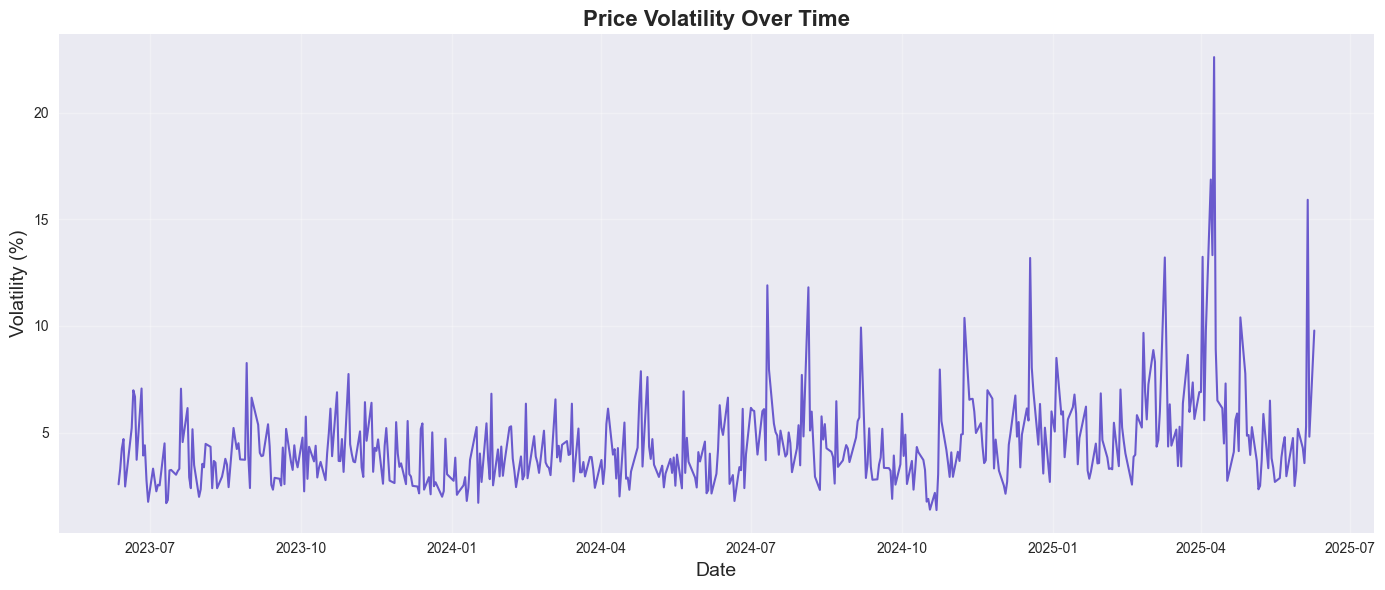

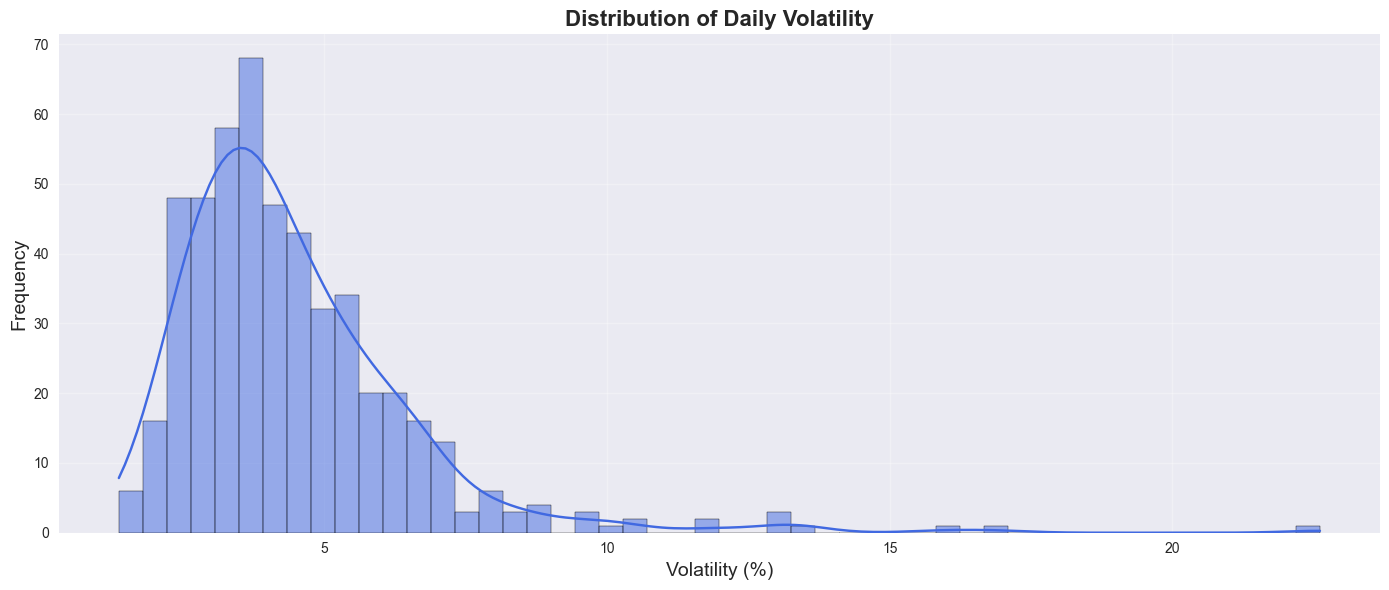

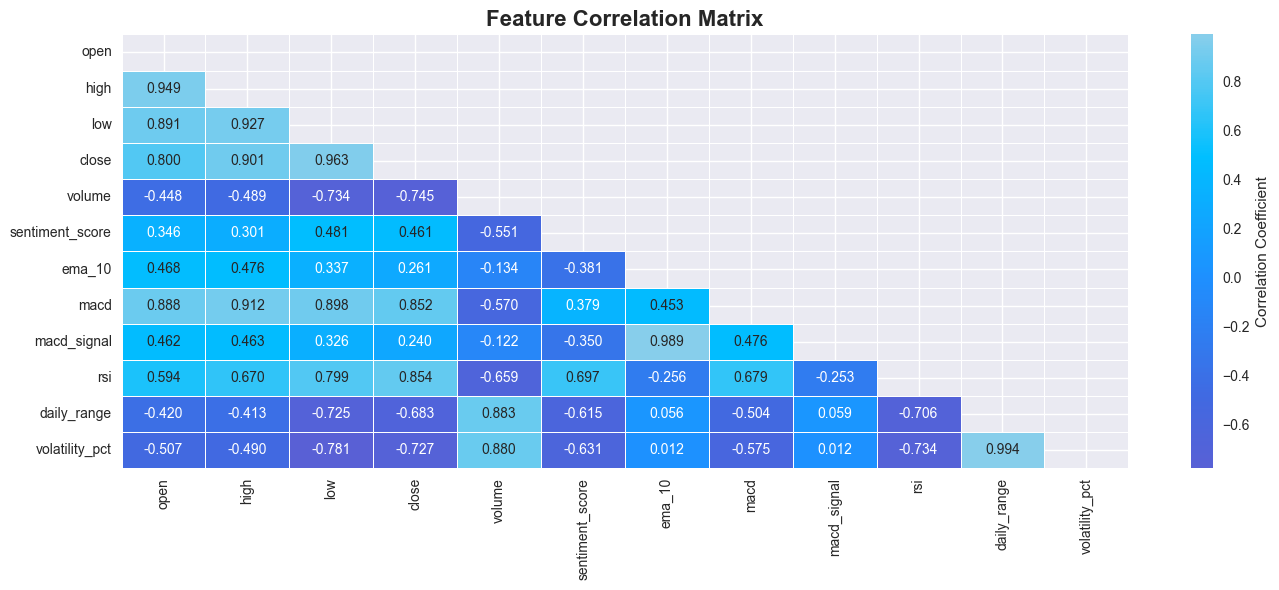

Key Correlations with Volatility:
  daily_range: 0.994
  volume: 0.880
  low: -0.781
  rsi: -0.734
  close: -0.727
  sentiment_score: -0.631
  macd: -0.575
  open: -0.507
  high: -0.490
  macd_signal: 0.012
  ema_10: 0.012


In [69]:
plt.figure(figsize=(14, 6))
plt.plot(df_merged['date'], df_merged['volatility_pct'], color=color_palette[0], linewidth=1.5)
plt.title('Price Volatility Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Volatility (%)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
sns.histplot(df_merged['volatility_pct'], bins=50, kde=True, color=color_palette[1])
plt.title('Distribution of Daily Volatility', fontsize=16, fontweight='bold')
plt.xlabel('Volatility (%)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


features = [
    'open', 'high', 'low', 'close', 'volume',
    'sentiment_score', 'ema_10', 'macd', 'macd_signal', 'rsi', 'daily_range',
    'volatility_pct',  # target
    ]

# 
df_corr_filtered = df_merged[df_merged['sentiment_score'] != 0.0][features].dropna()
corr_matrix = df_corr_filtered.corr()

from matplotlib.colors import LinearSegmentedColormap
cmap_purple_blue = LinearSegmentedColormap.from_list("purple_blue_diverging", color_palette, N=256)
mask = np.triu(np.ones_like(corr_matrix.corr()))


plt.figure(figsize=(14, 6))
sns.heatmap(corr_matrix, annot=True, mask = mask, cmap=cmap_purple_blue, center=0, fmt=".3f",
            linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("Key Correlations with Volatility:")
vol_corr = corr_matrix['volatility_pct'].drop('volatility_pct').sort_values(key=abs, ascending=False)
for feature, corr in vol_corr.items():
    print(f"  {feature}: {corr:.3f}")

## Machine Learning Modeling 

In [119]:
# initializing features, target and model
df_model = df_merged[[
    'open', 'high', 'low', 'close', 'volume', 'dividends', 'stock_splits',
    'sentiment_score', 'ema_10', 'macd', 'macd_signal', 'rsi', 'daily_range',
    'volatility_pct',  # target
    'rsi_lag1',
    'volatility_pct_lag1'  # new lag feature
]].dropna()

features = [
    'open', 'high', 'low', 'close', 'volume', 'dividends', 'stock_splits',
    'sentiment_score', 'ema_10', 'macd', 'macd_signal', 'rsi', 'daily_range',
    'rsi_lag1', 'volatility_pct_lag1'
]

X = df_model[features]
y = df_model['volatility_pct']

# evaluation & plotting functions
# def evaluate_model(name, y_true, y_pred):
#     rmse = np.sqrt(mean_squared_error(y_true, y_pred))
#     mae = mean_absolute_error(y_true, y_pred)
#     r2 = r2_score(y_true, y_pred)
    
#     print(f"\n{name} Performance:")
#     print(f"   RMSE: {rmse:.4f}")
#     print(f"   MAE:  {mae:.4f}")
#     print(f"   R²:   {r2:.4f}")
    
def plot_predictions(y_true, y_pred, title, color_idx=0):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true.values, label='Actual Volatility', 
             marker='o', linewidth=2, color=color_palette[color_idx], alpha=0.7)
    plt.plot(y_pred, label='Predicted Volatility', 
             marker='x', linewidth=2, linestyle='--', color=color_palette[color_idx+1], alpha=0.8)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Time Index', fontsize=12)
    plt.ylabel('Volatility (%)', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_residuals(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.figure(figsize=(12, 6))
    plt.scatter(range(len(residuals)), residuals, alpha=0.7)
    plt.hlines(0, 0, len(residuals), colors='red', linestyles='dashed')
    plt.title(title)
    plt.xlabel('Time Index')
    plt.ylabel('Residual')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Time Series Split
tscv = TimeSeriesSplit(n_splits=5)
train_index, test_index = list(tscv.split(X))[-1]

X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# model comparison set up
class ModelComparison:
    def __init__(self):
        self.results = []
        
    def add_model_result(self, model_name, y_true, y_pred, **kwargs):
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        
        result = {
            'Model': model_name,
            'RMSE': rmse,
            'MAE': mae,
            'R²': r2,
            **kwargs 
        }
        
        self.results.append(result)
        print(f"\n{model_name} Performance:")
        print(f"   RMSE: {rmse:.4f}")
        print(f"   MAE:  {mae:.4f}")
        print(f"   R²:   {r2:.4f}")
        
    def get_comparison_table(self):
    
        if not self.results:
            print("No model results to compare!")
            return None
        results_df = pd.DataFrame(self.results)
        results_df['RMSE_Rank'] = results_df['RMSE'].rank(ascending=True).astype(int)
        results_df['MAE_Rank'] = results_df['MAE'].rank(ascending=True).astype(int)  
        results_df['R²_Rank'] = results_df['R²'].rank(ascending=False).astype(int)
        results_df['Overall_Score'] = ((results_df['RMSE_Rank'] + results_df['MAE_Rank'] + results_df['R²_Rank']) / 3).round(2)
        results_df['Final_Rank'] = results_df['Overall_Score'].rank(ascending=True).astype(int)
        
        results_df_sorted = results_df.sort_values('Final_Rank').reset_index(drop=True)
        return results_df_sorted
    
    def print_comparison_summary(self, stock_ticker=""):
        results_df = self.get_comparison_table()
        
        if results_df is None:
            return   
        print(f"MODEL PERFORMANCE COMPARISON - {stock_ticker}")
        display_cols = ['Model', 'RMSE', 'MAE', 'R²', 'RMSE_Rank', 'MAE_Rank', 'R²_Rank', 'Final_Rank']
        print("\nPerformance Metrics & Rankings:")
        print(results_df[display_cols].to_string(index=False, float_format='%.4f'))
        print("PERFORMANCE INSIGHTS")
        best_overall = results_df.iloc[0]
        best_rmse = results_df.loc[results_df['RMSE_Rank'] == 1].iloc[0]
        best_mae = results_df.loc[results_df['MAE_Rank'] == 1].iloc[0]
        best_r2 = results_df.loc[results_df['R²_Rank'] == 1].iloc[0]
        
        print(f"\n BEST OVERALL MODEL: {best_overall['Model']}")
        
        print(f"\n BEST BY INDIVIDUAL METRICS:")
        print(f"   Lowest RMSE: {best_rmse['Model']} ({best_rmse['RMSE']:.4f})")
        print(f"   Lowest MAE:  {best_mae['Model']} ({best_mae['MAE']:.4f})")  
        print(f"   Highest R²:  {best_r2['Model']} ({best_r2['R²']:.4f})")
        
        excellent_models = results_df[results_df['R²'] >= 0.95]
        good_models = results_df[(results_df['R²'] >= 0.80) & (results_df['R²'] < 0.95)]
        needs_work = results_df[results_df['R²'] < 0.80]
        
        print(f"\n PERFORMANCE CATEGORIES:")
        if len(excellent_models) > 0:
            print(f"   Excellent (R² ≥ 0.95): {', '.join(excellent_models['Model'].tolist())}")
        if len(good_models) > 0:
            print(f"   Good (R² 0.80-0.95): {', '.join(good_models['Model'].tolist())}")
        if len(needs_work) > 0:
            print(f"   Needs Work (R² < 0.80): {', '.join(needs_work['Model'].tolist())}")
            
    def plot_comparison(self, figsize=(15, 10)):
        results_df = self.get_comparison_table()
        
        if results_df is None:
            return
            
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        colors = color_palette
    
        # RMSE Comparison
        axes[0,0].bar(range(len(results_df)), results_df['RMSE'], color=colors[:len(results_df)])
        axes[0,0].set_title('RMSE Comparison (Lower is Better)', fontweight='bold')
        axes[0,0].set_ylabel('RMSE')
        axes[0,0].set_xticks(range(len(results_df)))
        axes[0,0].set_xticklabels(results_df['Model'], rotation=45, ha='right')
        
        # MAE Comparison  
        axes[0,1].bar(range(len(results_df)), results_df['MAE'], color=colors[:len(results_df)])
        axes[0,1].set_title('MAE Comparison (Lower is Better)', fontweight='bold')
        axes[0,1].set_ylabel('MAE')
        axes[0,1].set_xticks(range(len(results_df)))
        axes[0,1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
        
        # R² Comparison
        axes[1,0].bar(range(len(results_df)), results_df['R²'], color=colors[:len(results_df)])
        axes[1,0].set_title('R² Comparison (Higher is Better)', fontweight='bold')
        axes[1,0].set_ylabel('R² Score')
        axes[1,0].set_xticks(range(len(results_df)))
        axes[1,0].set_xticklabels(results_df['Model'], rotation=45, ha='right')
        
        # Overall Ranking
        axes[1,1].bar(range(len(results_df)), results_df['Final_Rank'], color=colors[:len(results_df)])
        axes[1,1].set_title('Overall Ranking (Lower Rank = Better)', fontweight='bold')
        axes[1,1].set_ylabel('Final Rank')
        axes[1,1].set_xticks(range(len(results_df)))
        axes[1,1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
        axes[1,1].invert_yaxis()  # Invert so rank 1 appears at top
        
        plt.tight_layout()
        plt.show()

model_comparison = ModelComparison()


### Baseline Linear Regression


Baseline Linear Regression Performance:
   RMSE: 0.7060
   MAE:  0.3975
   R²:   0.9595
Linear Regression Feature Coefficients (sorted by importance):
                Feature   Coefficient
0           daily_range  2.183054e-01
1                  high  1.106796e-01
2                   low -1.076258e-01
3                  macd -4.311407e-02
4           macd_signal  2.725940e-02
5                  open -2.447963e-02
6                   rsi  2.271612e-02
7   volatility_pct_lag1 -1.333695e-02
8                ema_10  1.143571e-02
9                 close -4.426261e-03
10             rsi_lag1  1.937555e-03
11               volume  5.482383e-09
12            dividends  5.551115e-17
13         stock_splits -5.551115e-17
14      sentiment_score  1.214306e-17


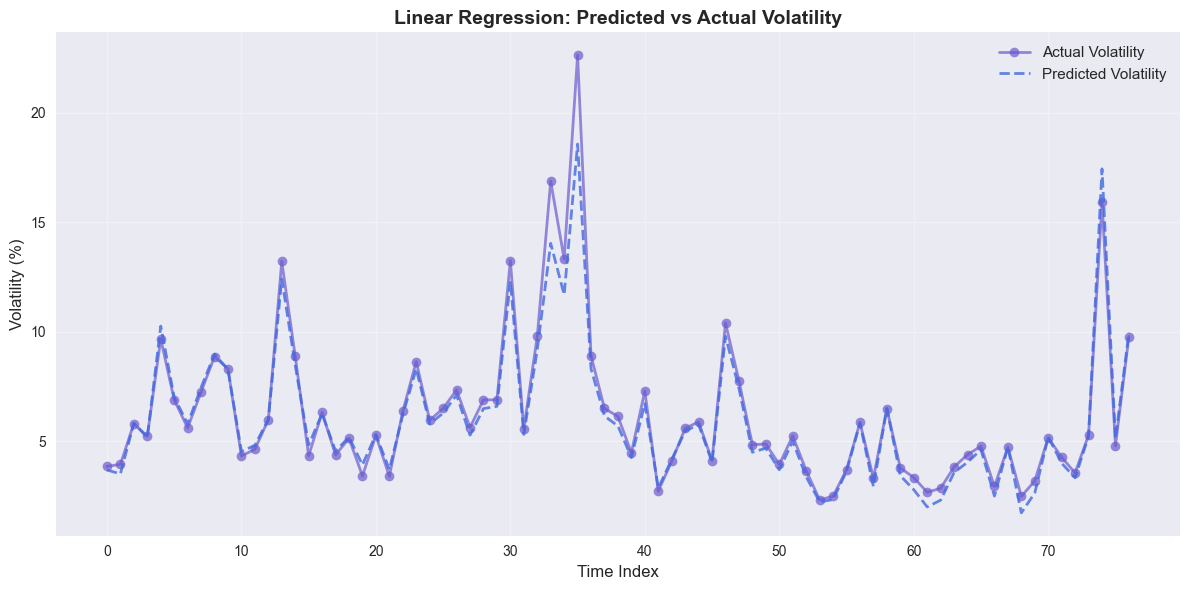

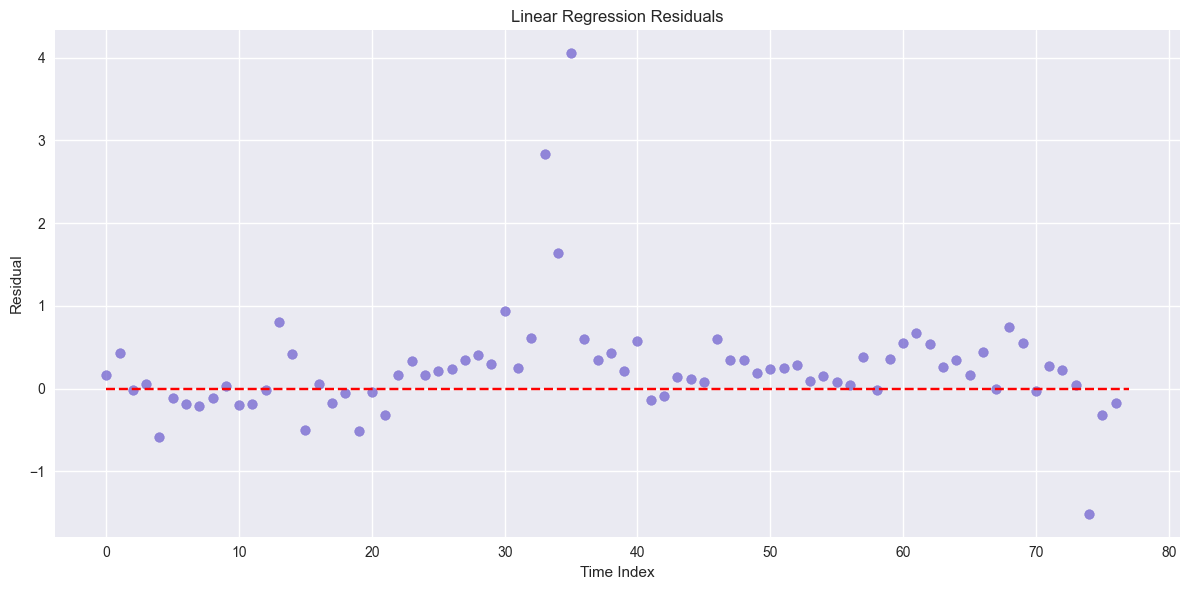

In [120]:
# fit lr
lr = LinearRegression()
lr.fit(X_train, y_train)

# predict & evaluate
y_pred = lr.predict(X_test)
model_comparison.add_model_result("Baseline Linear Regression", y_test, y_pred)

# coeff analysis
coef = lr.coef_
features = X.columns
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coef,
    'AbsCoefficient': np.abs(coef)
})

# sort by abs coefficient value descending (importance)
coef_df_sorted = coef_df.sort_values(by='AbsCoefficient', ascending=False).reset_index(drop=True)
print("Linear Regression Feature Coefficients (sorted by importance):")
print(coef_df_sorted[['Feature', 'Coefficient']])

plot_predictions(y_test, y_pred, "Linear Regression: Predicted vs Actual Volatility", color_idx=0)
plot_residuals(y_test, y_pred, "Linear Regression Residuals")

### Regularized Models (Ridge, Lasso)

In [121]:
# Ridge Regression
ridge_alphas = np.logspace(-3, 3, 100)
ridge_model = make_pipeline(StandardScaler(), RidgeCV(alphas=ridge_alphas, cv=5))
ridge_model.fit(X, y)

# predict & evaluate
ridge_preds = ridge_model.predict(X)
model_comparison.add_model_result("RidgeCV",y, ridge_preds)

# Lasso Regression (Feature selection)
lasso_alphas = np.logspace(-3, 3, 100)
lasso_model = make_pipeline(StandardScaler(), LassoCV(alphas=lasso_alphas, cv=5, max_iter=5000))
lasso_model.fit(X, y)

lasso_preds = lasso_model.predict(X)
model_comparison.add_model_result("LassoCV",y, lasso_preds)


RidgeCV Performance:
   RMSE: 0.4825
   MAE:  0.3055
   R²:   0.9514

LassoCV Performance:
   RMSE: 0.4835
   MAE:  0.3025
   R²:   0.9512


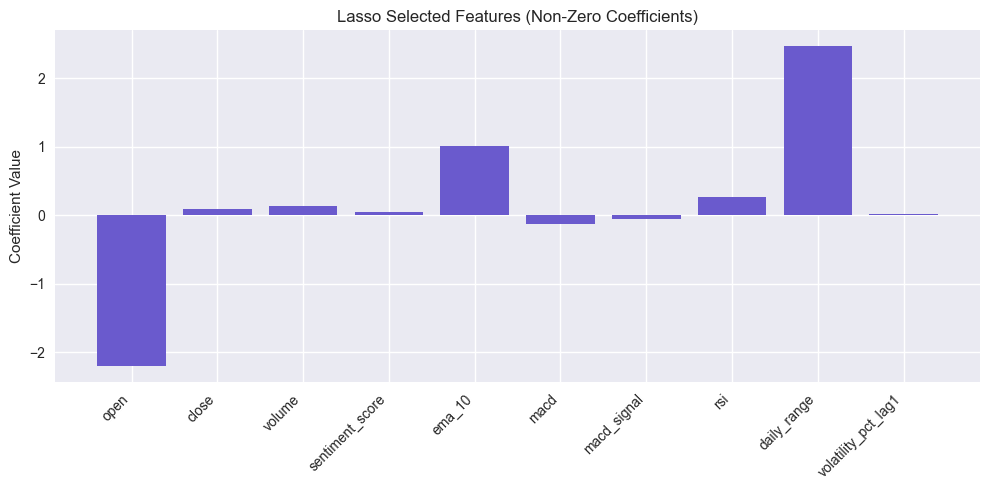

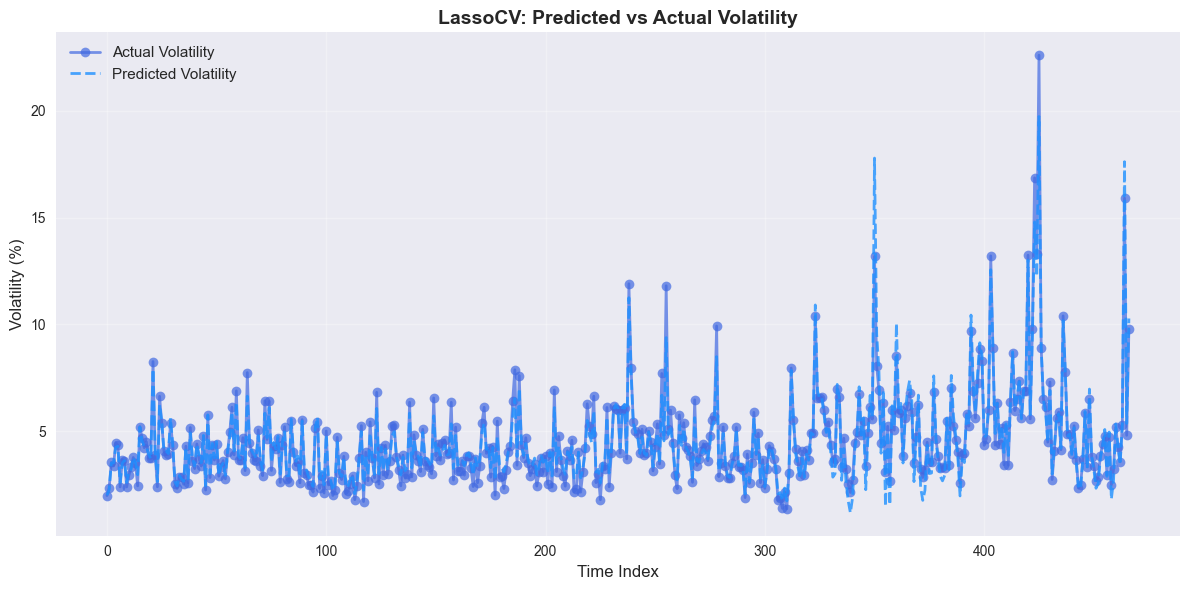

In [122]:
# analyzing LassoCV performance
lasso_coefs = lasso_model.named_steps['lassocv'].coef_
features_selected = X.columns[lasso_coefs != 0]

# non-zero coefficients
plt.figure(figsize=(10, 5))
plt.bar(features_selected, lasso_coefs[lasso_coefs != 0])
plt.xticks(rotation=45, ha='right')
plt.title("Lasso Selected Features (Non-Zero Coefficients)")
plt.ylabel("Coefficient Value")
plt.tight_layout()
plt.show()

plot_predictions(y, lasso_preds, "LassoCV: Predicted vs Actual Volatility", color_idx=1)

### Tree-Based Models (Random Forest, Gradient Boosting)


Random Forest Performance:
   RMSE: 2.0855
   MAE:  1.0423
   R²:   0.6463


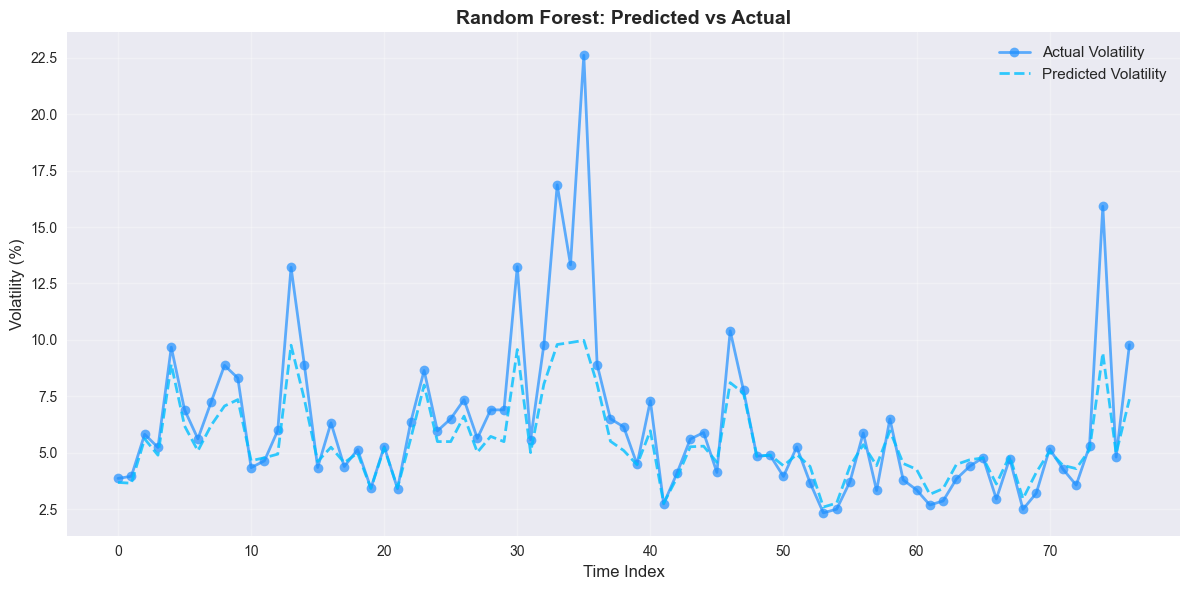

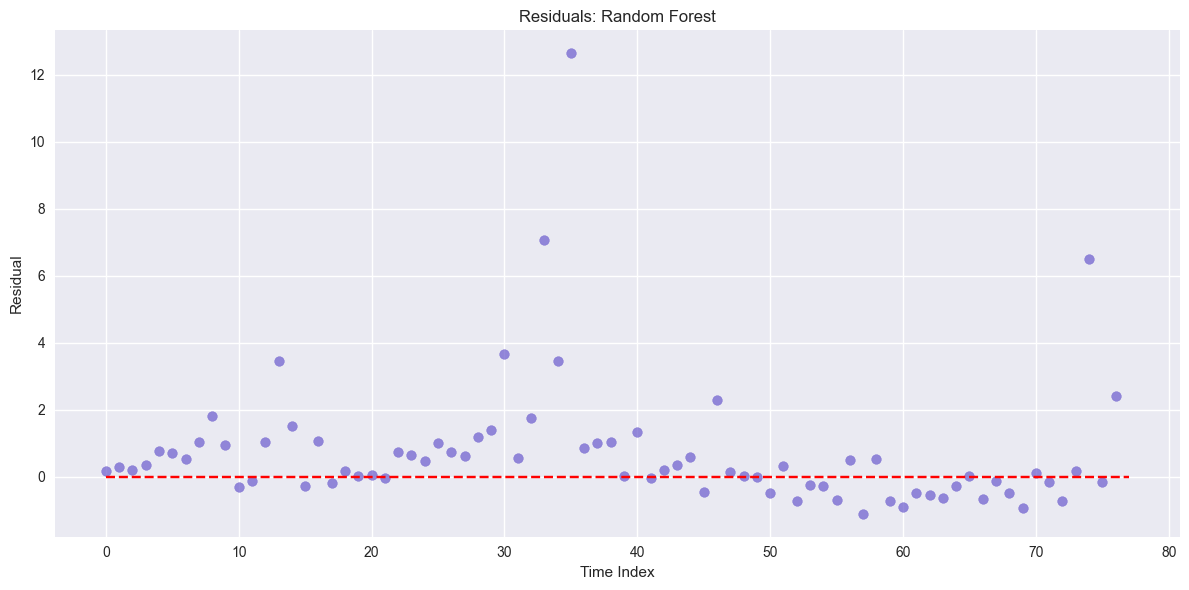


Tuned Gradient Boosting Performance:
   RMSE: 1.6748
   MAE:  0.6573
   R²:   0.7719


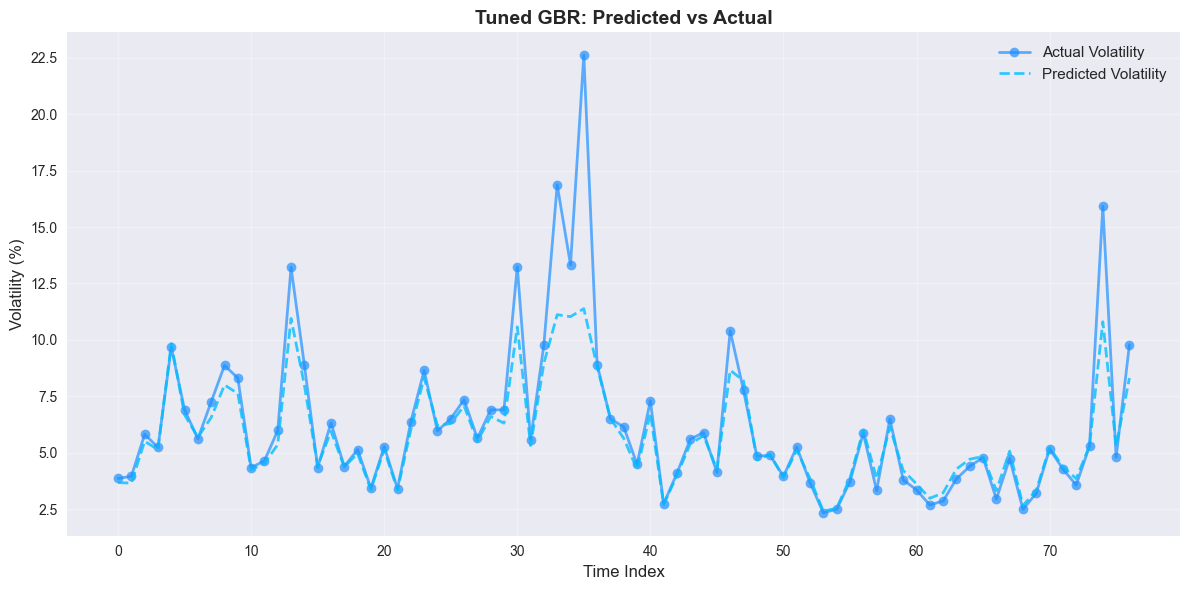

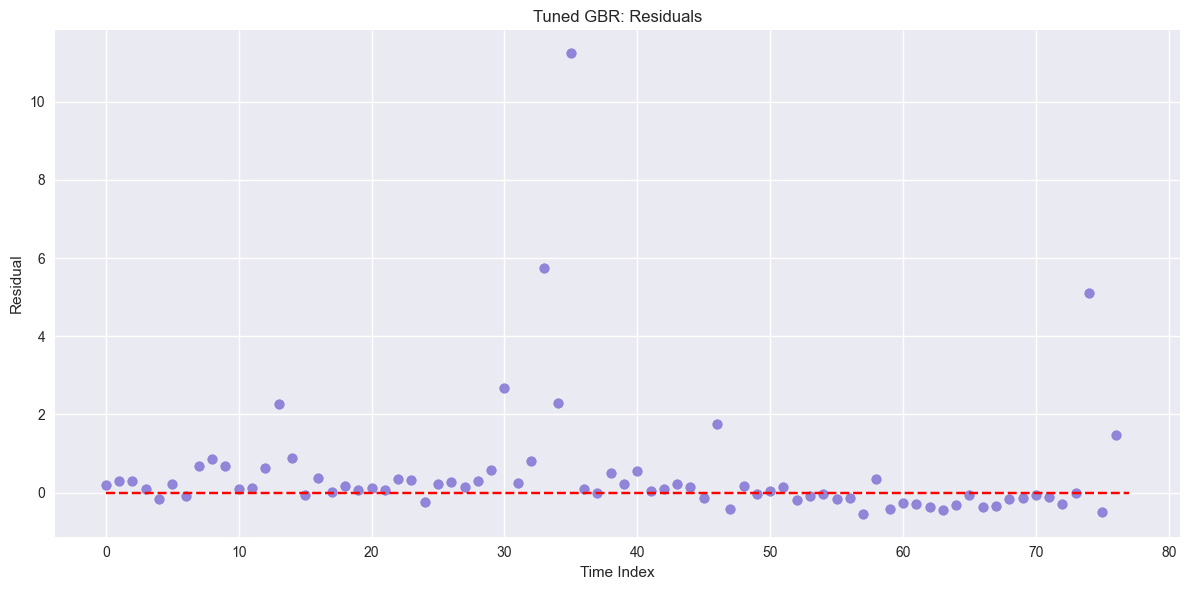

In [123]:
rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)
y_rf_pred = rf.predict(X_test)

model_comparison.add_model_result("Random Forest", y_test, y_rf_pred)

plot_predictions(y_test, y_rf_pred, "Random Forest: Predicted vs Actual",color_idx=2)
plot_residuals(y_test, y_rf_pred, "Residuals: Random Forest")

gbr = GradientBoostingRegressor(
    learning_rate=0.01,         # slower, more precise learning
    n_estimators=1000,          # more boosting rounds
    max_depth=3,                # lower to prevent overfitting
    min_samples_split=5,        # more conservative splits
    subsample=0.8,              # random sampling for robustness
    random_state=42
)

gbr.fit(X_train, y_train)
y_gbr_pred = gbr.predict(X_test)
model_comparison.add_model_result("Tuned Gradient Boosting", y_test, y_gbr_pred)
plot_predictions(y_test, y_gbr_pred, "Tuned GBR: Predicted vs Actual", color_idx=2)
plot_residuals(y_test, y_gbr_pred, "Tuned GBR: Residuals")

### MLP Regressor


MLPRegressor Performance:
   RMSE: 0.4824
   MAE:  0.3138
   R²:   0.9811


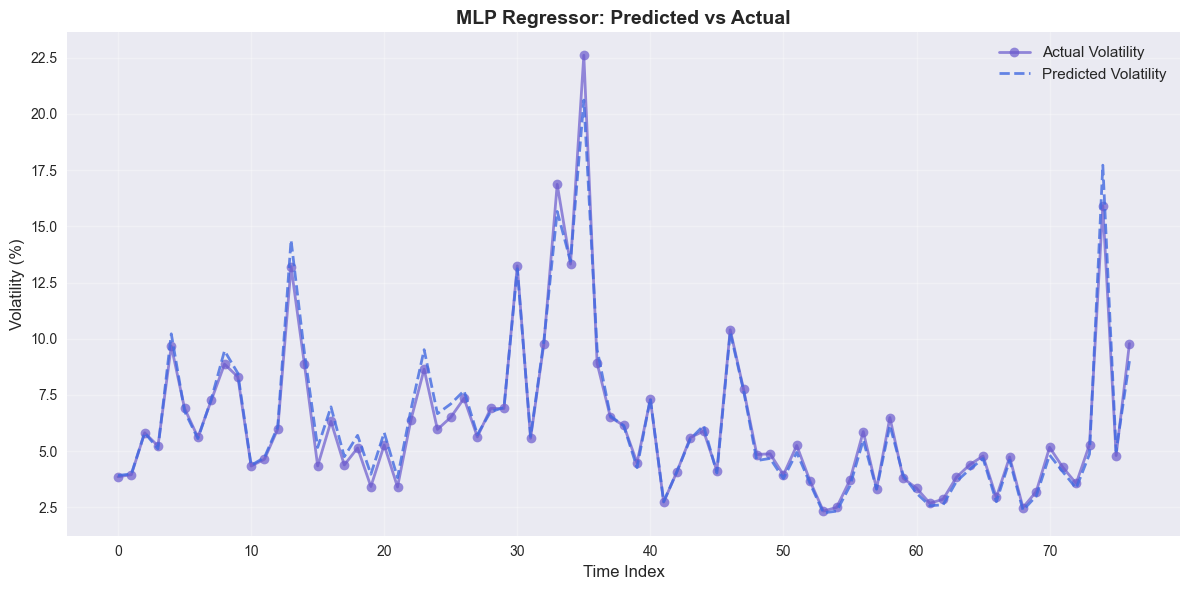

In [135]:
# standardizing features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# MLP regressor - final config after multiple trials 
mlp = MLPRegressor(hidden_layer_sizes=(256,128,64),
                   activation='relu',
                   solver='adam',
                   max_iter=1000,
                   early_stopping=True,
                   random_state=42)

# other configs
mlp1 = MLPRegressor(hidden_layer_sizes=(256,128,64),
                   activation='relu',
                   solver='adam',
                   max_iter=1500,
                   early_stopping=True,
                   random_state=42)
mlp2 = MLPRegressor(hidden_layer_sizes=(64,64),
                   activation='elu',
                   solver='adam',
                   max_iter=1000,
                   early_stopping=True,
                   random_state=42)

mlp.fit(X_train_scaled, y_train)
y_pred = mlp.predict(X_test_scaled)

model_comparison.add_model_result("MLPRegressor",y_test, y_pred)
plot_predictions(y_test, y_pred, "MLP Regressor: Predicted vs Actual", color_idx= 0)


## Model Evaluation & Validation

MODEL PERFORMANCE COMPARISON - TSLA

Performance Metrics & Rankings:
                     Model   RMSE    MAE     R²  RMSE_Rank  MAE_Rank  R²_Rank  Final_Rank
              MLPRegressor 0.4824 0.3138 0.9811          1         3        1           1
                   RidgeCV 0.4825 0.3055 0.9514          2         2        4           2
                   LassoCV 0.4835 0.3025 0.9512          3         1        5           3
              MLPRegressor 0.6350 0.4687 0.9672          4         5        2           4
Baseline Linear Regression 0.7060 0.3975 0.9595          5         4        3           5
   Tuned Gradient Boosting 1.6748 0.6573 0.7719          6         6        6           6
             Random Forest 2.0855 1.0423 0.6463          7         7        7           7
PERFORMANCE INSIGHTS

 BEST OVERALL MODEL: MLPRegressor

 BEST BY INDIVIDUAL METRICS:
   Lowest RMSE: MLPRegressor (0.4824)
   Lowest MAE:  LassoCV (0.3025)
   Highest R²:  MLPRegressor (0.9811)

 PERFORMANCE CA

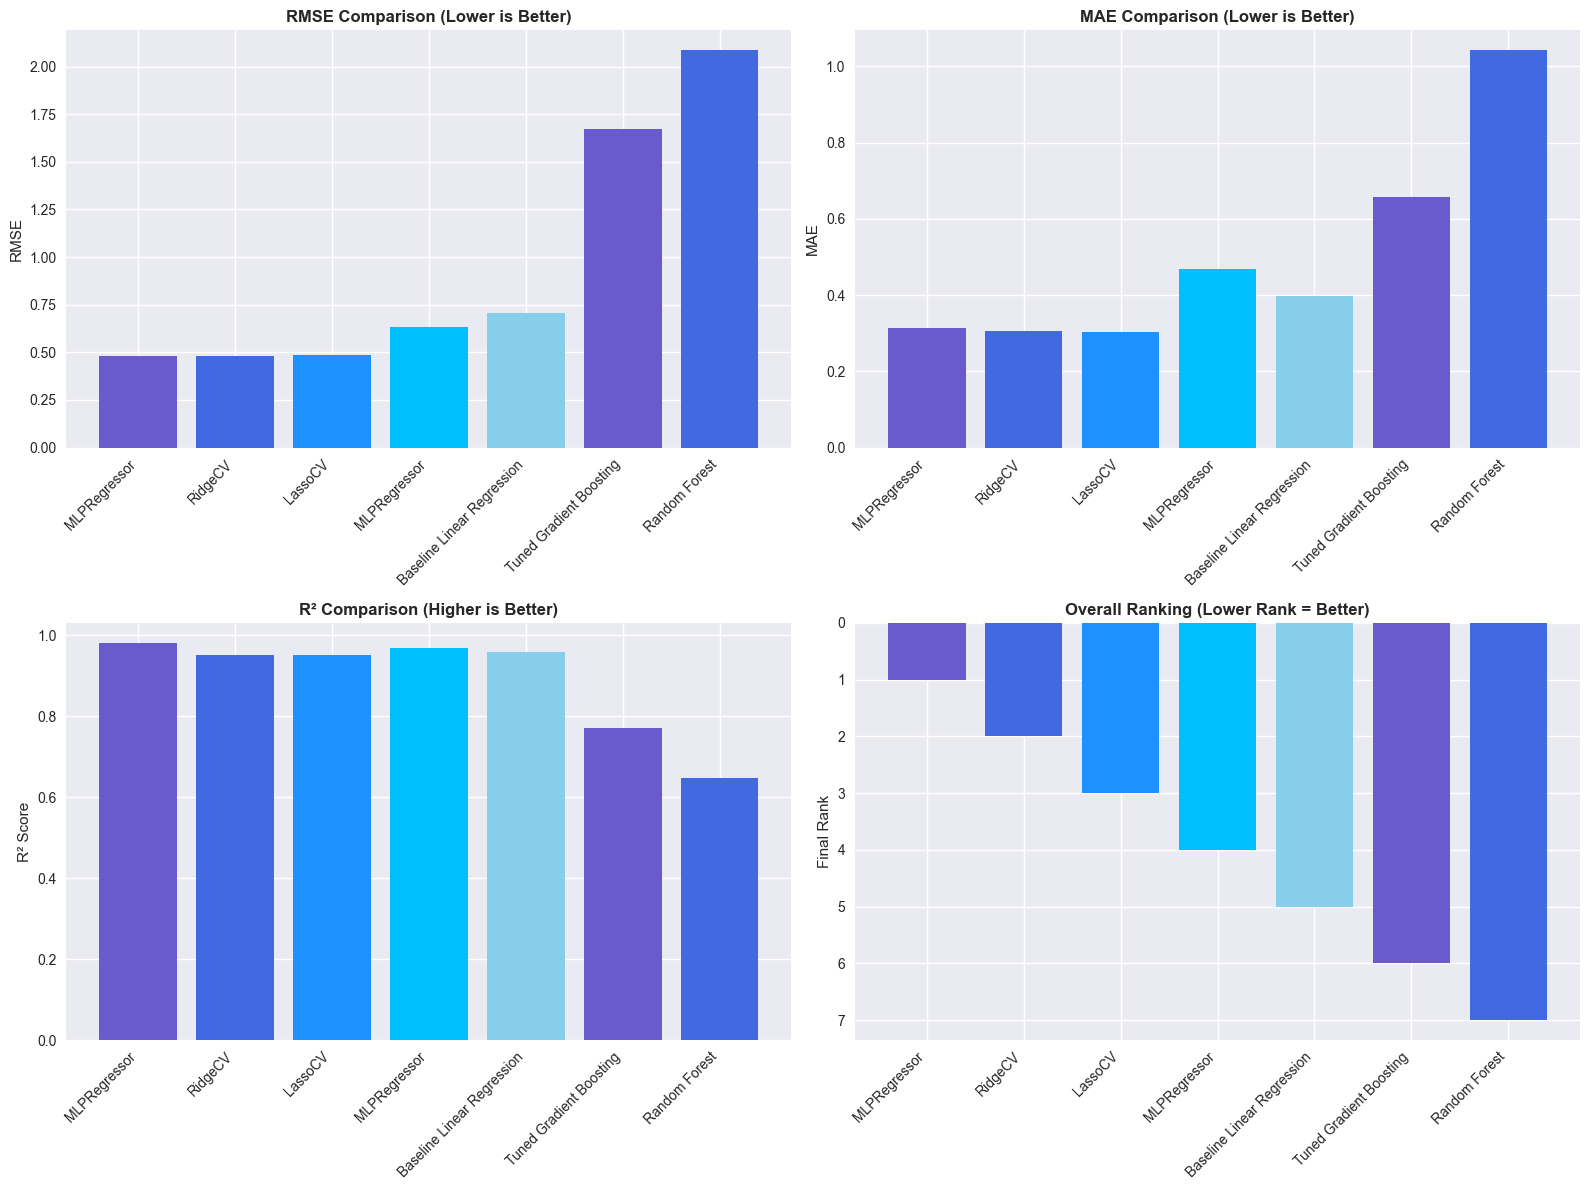

In [136]:
model_comparison.print_comparison_summary(STOCK_TICKER)  
model_comparison.plot_comparison(figsize=(16, 12))
results_df = model_comparison.get_comparison_table()

Avoids data leakage: Traditional cross-validation shuffles data randomly, which would allow your model to "see" future information when training on time series data. This leads to overly optimistic performance estimates. Walk-forward validation strictly maintains chronological order.
Mimics real-world deployment: In most time series forecasting scenarios (e.g., stock prices, sales forecasting), you train on past data and predict the future. Walk-forward validation accurately reflects this.
Accounts for concept drift: 


--- Starting Walk-Forward Validation for All Models ---

--- Performing Walk-Forward Validation for: Baseline Linear Regression ---

Baseline Linear Regression - Overall Walk-Forward Validation Results:
  Overall RMSE: 0.9463
  Overall MAE:  0.5136
  Overall R²:   0.8959


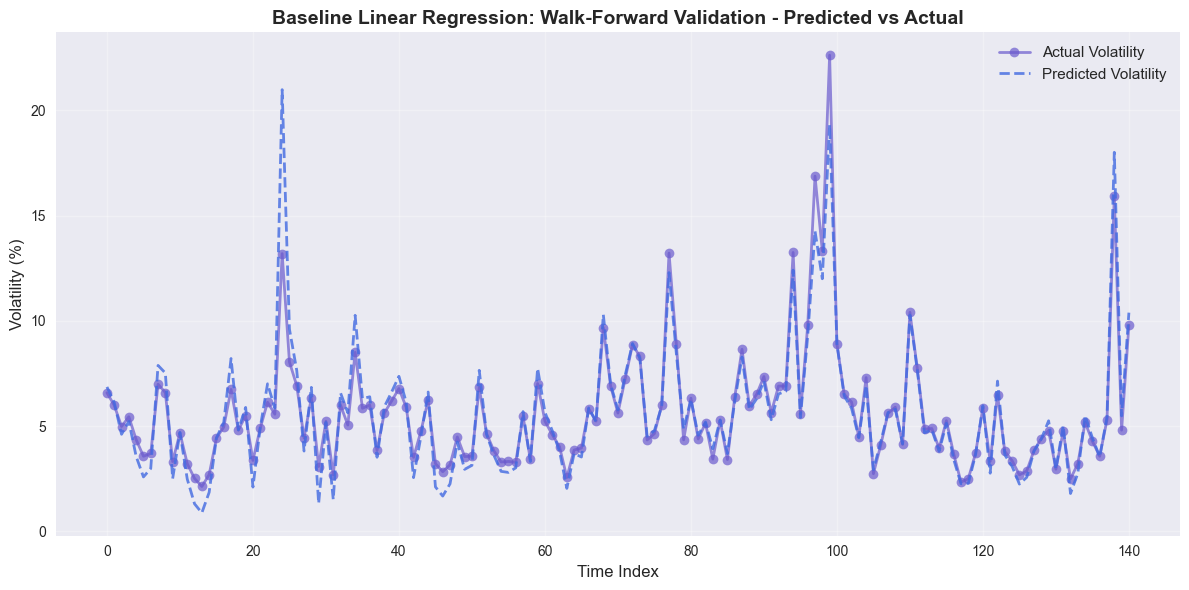


--- Performing Walk-Forward Validation for: RidgeCV ---

RidgeCV - Overall Walk-Forward Validation Results:
  Overall RMSE: 0.9735
  Overall MAE:  0.5153
  Overall R²:   0.8899


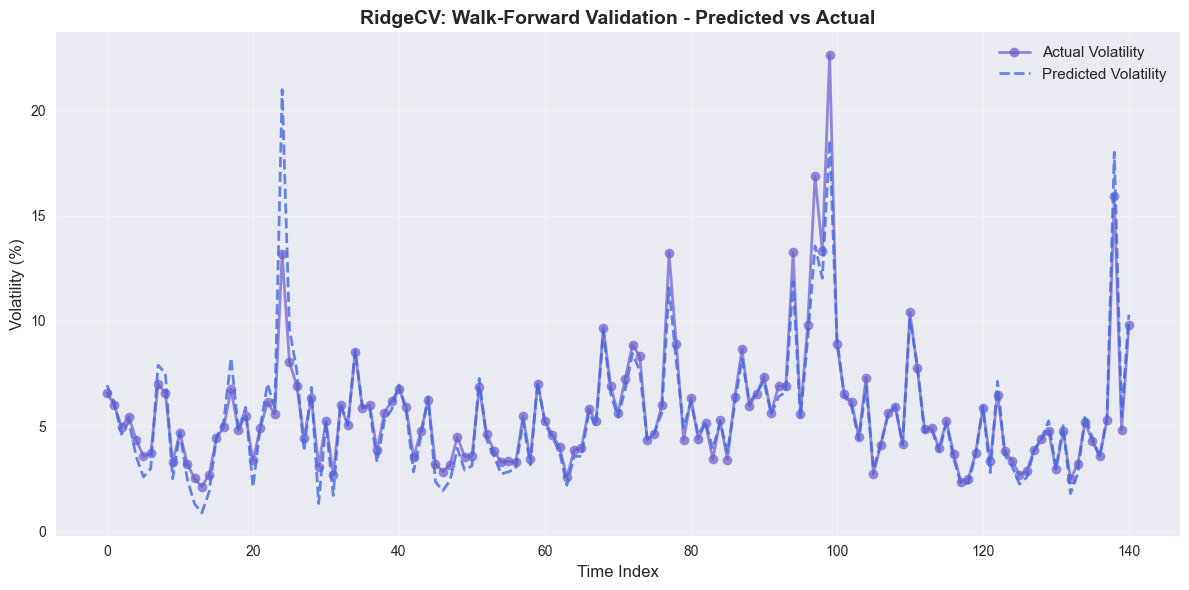


--- Performing Walk-Forward Validation for: LassoCV ---

LassoCV - Overall Walk-Forward Validation Results:
  Overall RMSE: 1.0020
  Overall MAE:  0.5296
  Overall R²:   0.8833


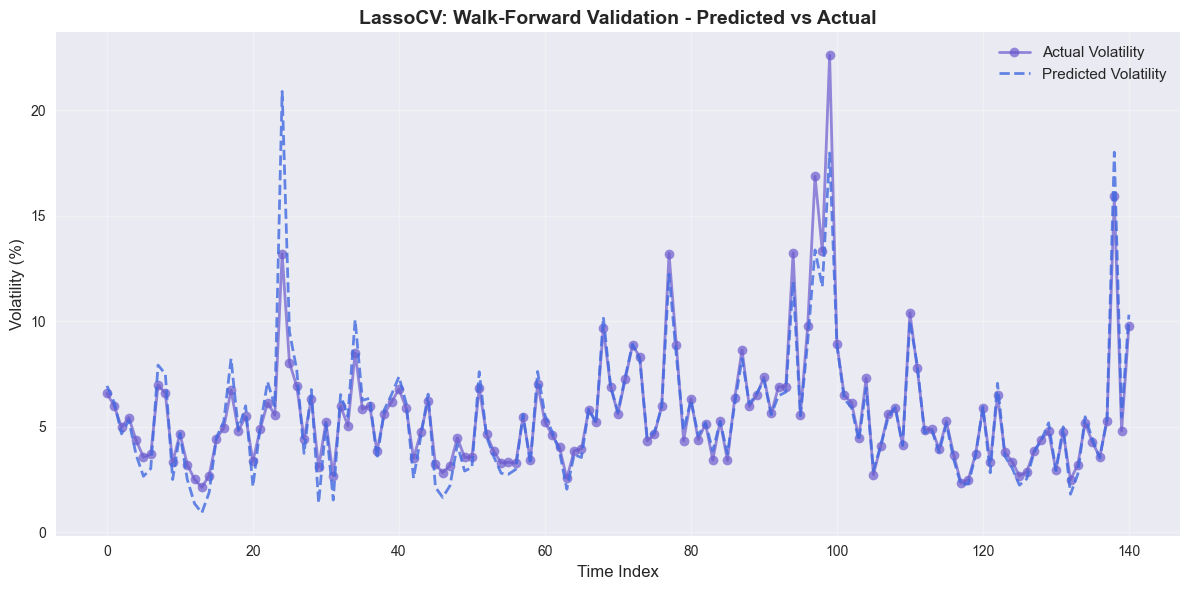


--- Performing Walk-Forward Validation for: Random Forest ---

Random Forest - Overall Walk-Forward Validation Results:
  Overall RMSE: 1.2756
  Overall MAE:  0.7557
  Overall R²:   0.8109


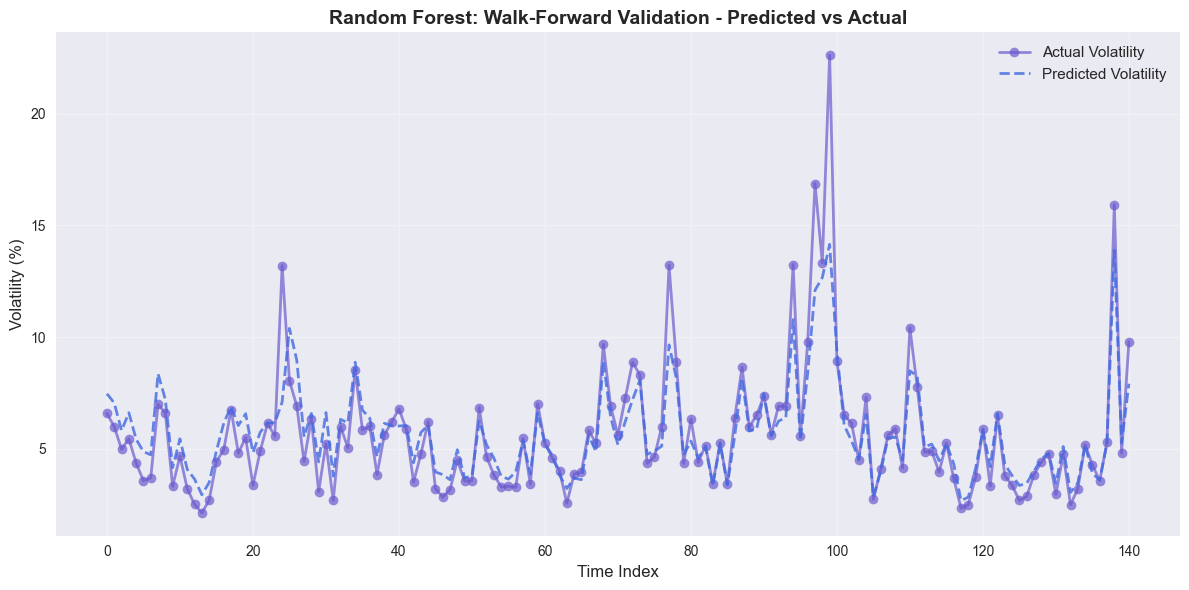


--- Performing Walk-Forward Validation for: Tuned Gradient Boosting ---

Tuned Gradient Boosting - Overall Walk-Forward Validation Results:
  Overall RMSE: 1.0004
  Overall MAE:  0.4403
  Overall R²:   0.8837


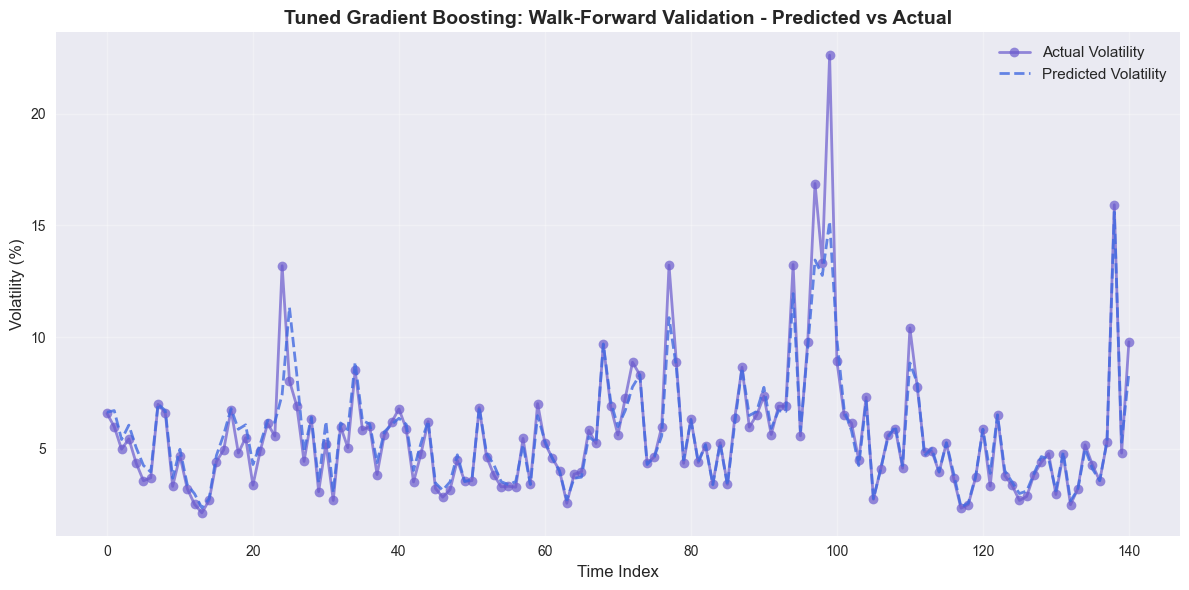


--- Performing Walk-Forward Validation for: MLPRegressor ---

MLPRegressor - Overall Walk-Forward Validation Results:
  Overall RMSE: 0.8113
  Overall MAE:  0.4062
  Overall R²:   0.9235


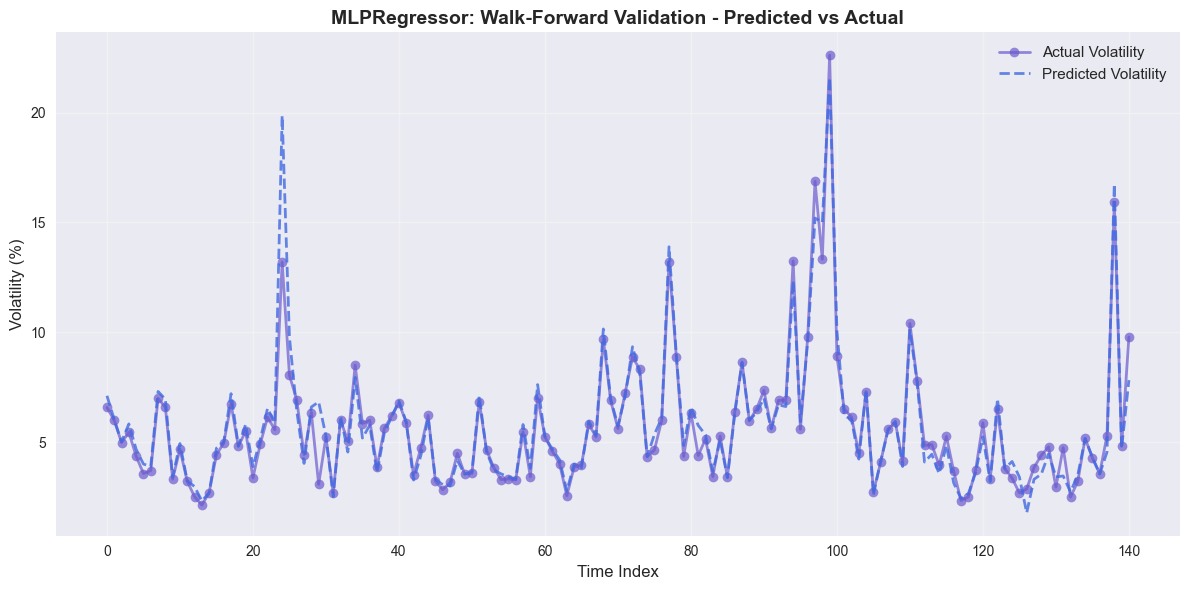


--- Summary of All Models' Walk-Forward Validation Results ---
                        Model  WF_RMSE  WF_MAE  WF_R²
0                MLPRegressor   0.8113  0.4062 0.9235
1  Baseline Linear Regression   0.9463  0.5136 0.8959
2                     RidgeCV   0.9735  0.5153 0.8899
3     Tuned Gradient Boosting   1.0004  0.4403 0.8837
4                     LassoCV   1.0020  0.5296 0.8833
5               Random Forest   1.2756  0.7557 0.8109


In [ ]:
# Walk-Forward Validation 
def run_walk_forward_validation(models_dict, X, y, initial_train_ratio=0.7, test_window_size=1):
    walk_forward_results = []
    
    initial_train_size = int(len(X) * initial_train_ratio)

    if initial_train_size <= 0 or initial_train_size >= len(X):
        raise ValueError("initial_train_ratio results in an invalid initial training size. "
                         "Ensure it's between 0 and 1 and leaves enough data for testing.")
    if test_window_size <= 0:
        raise ValueError("test_window_size must be a positive integer.")
    if initial_train_size + test_window_size > len(X):
         raise ValueError("initial_train_ratio + test_window_size is too large for the dataset size.")



    for model_name, model in models_dict.items():
        print(f"\nPerforming Walk-Forward Validation for: {model_name} ")

        all_y_true_wf = []
        all_y_pred_wf = []
        

        for i in range(initial_train_size, len(X) - test_window_size + 1):
            
            train_end_idx = i
            test_start_idx = i
            test_end_idx = i + test_window_size

            X_train_wf, y_train_wf = X.iloc[:train_end_idx], y.iloc[:train_end_idx]
            X_test_wf, y_test_wf = X.iloc[test_start_idx:test_end_idx], y.iloc[test_start_idx:test_end_idx]
            
            if len(y_test_wf) == 0:
                continue

            if isinstance(model, MLPRegressor) and any(isinstance(step, MLPRegressor) for step in model.steps):
                if not isinstance(model, pd.Pipeline):
                    wf_scaler = StandardScaler()
                    X_train_wf_scaled = wf_scaler.fit_transform(X_train_wf)
                    X_test_wf_scaled = wf_scaler.transform(X_test_wf)
                    model.fit(X_train_wf_scaled, y_train_wf)
                    y_pred_wf = model.predict(X_test_wf_scaled)
                else: # pipeline model handles scaling
                    model.fit(X_train_wf, y_train_wf)
                    y_pred_wf = model.predict(X_test_wf)
            else: 
                model.fit(X_train_wf, y_train_wf)
                y_pred_wf = model.predict(X_test_wf)

            all_y_true_wf.extend(y_test_wf.tolist())
            all_y_pred_wf.extend(y_pred_wf.tolist())
        
        # overall metrics for walk forward
        if len(all_y_true_wf) > 0:
            wf_rmse = np.sqrt(mean_squared_error(all_y_true_wf, all_y_pred_wf))
            wf_mae = mean_absolute_error(all_y_true_wf, all_y_pred_wf)
            wf_r2 = r2_score(all_y_true_wf, all_y_pred_wf)
            
            print(f"\n{model_name} - Walk-Forward Results:")
            print(f"  Overall RMSE: {wf_rmse:.4f}")
            print(f"  Overall MAE:  {wf_mae:.4f}")
            print(f"  Overall R²:   {wf_r2:.4f}")

            walk_forward_results.append({
                'Model': model_name,
                'WF_RMSE': wf_rmse,
                'WF_MAE': wf_mae,
                'WF_R²': wf_r2
            })
            
            
            plot_predictions(pd.Series(all_y_true_wf), pd.Series(all_y_pred_wf),
                             f"{model_name}: Walk-Forward - Predicted vs Actual", color_idx=0)
        else:
            print(f"  Not enough data for walk-forward validation for {model_name} with current parameters.")
            
    return pd.DataFrame(walk_forward_results).sort_values(by='WF_RMSE', ascending=True).reset_index(drop=True)

models_to_evaluate = {
    "Baseline Linear Regression": LinearRegression(),
    "RidgeCV": make_pipeline(StandardScaler(), RidgeCV(alphas=np.logspace(-3, 3, 100), cv=5)),
    "LassoCV": make_pipeline(StandardScaler(), LassoCV(alphas=np.logspace(-3, 3, 100), cv=5, max_iter=5000)),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
    "Tuned Gradient Boosting": GradientBoostingRegressor(learning_rate=0.01, n_estimators=1000, max_depth=3, min_samples_split=5, subsample=0.8, random_state=42),
    "MLPRegressor": make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=(64,64,64), activation='relu', solver='adam', max_iter=1000, early_stopping=True, random_state=42))
}

final_wf_results_df = run_walk_forward_validation(
    models_to_evaluate,
    X,
    y,
    initial_train_ratio=0.7,
    test_window_size=1     
)

print("\nSummary of Walk-Forward Validation Results ")
print(final_wf_results_df.to_string(float_format='%.4f'))


Best Performing Model (based on Walk-Forward RMSE): MLPRegressor
  RMSE: 0.8113
  MAE:  0.4062
  R²:   0.9235

 Analyzing Behavior of the Best Model: MLPRegressor


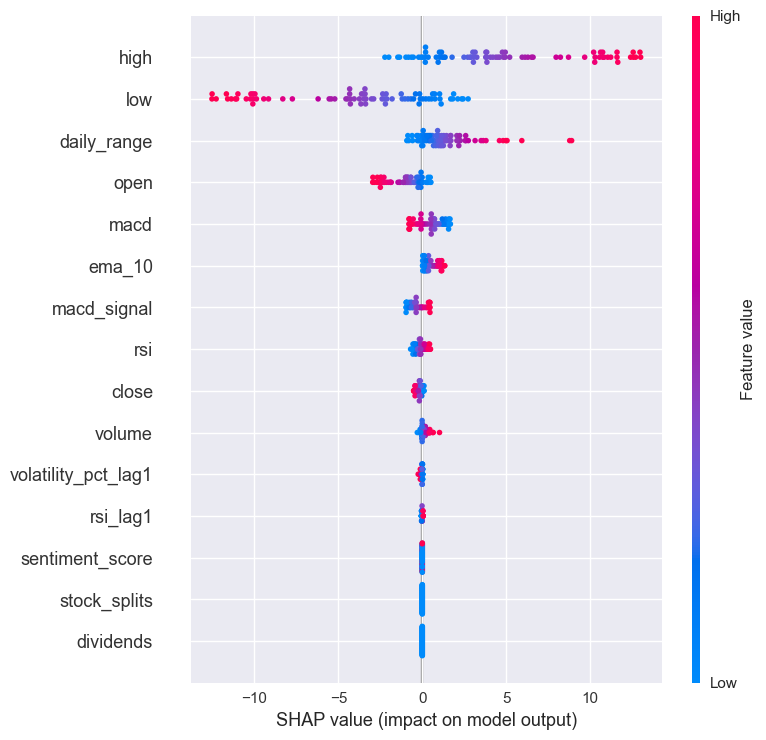

In [147]:

# identify best performing model
if not final_wf_results_df.empty:
    best_model_name = final_wf_results_df.iloc[0]['Model']
    best_model_metrics = final_wf_results_df.iloc[0]
    print(f"\nBest Performing Model (based on Walk-Forward RMSE): {best_model_name}")
    print(f"  RMSE: {best_model_metrics['WF_RMSE']:.4f}")
    print(f"  MAE:  {best_model_metrics['WF_MAE']:.4f}")
    print(f"  R²:   {best_model_metrics['WF_R²']:.4f}")

    print(f"\n Analyzing Behavior of the Best Model: {best_model_name}")

# shap for feature relation for best model
import shap
explainer = shap.Explainer(lr, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)


